In [23]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import logging

In [25]:
# Configure logging for runtime info
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')


# === Task 4: Basic CRR binomial pricer ===
def _price_european(u, d, p, S0, K, r, dt, N, option_type):
    """Backward induction for European option."""
    payoff = [
        max((S0 * u**j * d**(N - j)) - K, 0.0) if option_type == 'C'
        else max(K - (S0 * u**j * d**(N - j)), 0.0)
        for j in range(N + 1)
    ]
    disc = math.exp(-r * dt)
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            payoff[j] = disc * (p * payoff[j + 1] + (1 - p) * payoff[j])
    return payoff[0]


def _price_american(u, d, p, S0, K, r, dt, N, option_type):
    """Backward induction for American option with early exercise."""
    payoff = [
        max((S0 * u**j * d**(N - j)) - K, 0.0) if option_type == 'C'
        else max(K - (S0 * u**j * d**(N - j)), 0.0)
        for j in range(N + 1)
    ]
    disc = math.exp(-r * dt)
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            cont = disc * (p * payoff[j + 1] + (1 - p) * payoff[j])
            sp = S0 * u**j * d**(i - j)
            exercise = max(sp - K, 0.0) if option_type == 'C' else max(K - sp, 0.0)
            payoff[j] = max(cont, exercise)
    return payoff[0]


def crr_pricer(option, K, T, S0, sigma, r, q, N, exercise):
    """
    Task 4:
    Cox‑Ross‑Rubinstein binomial model for European/American options.
    Returns (price, elapsed_time).
    """
    start = time.time()
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    p = (math.exp((r - q) * dt) - d) / (u - d)

    if exercise == 'E':
        price = _price_european(u, d, p, S0, K, r, dt, N, option)
    else:
        price = _price_american(u, d, p, S0, K, r, dt, N, option)

    elapsed = time.time() - start
    logging.info(f"[Task 4] CRR {exercise} N={N} → price={price:.5f} time={elapsed:.4f}s")
    return price, elapsed

# Conclusion Task 4: CRR pricer implemented, supports C/P, E/A, returns price and timing.



[INFO] [Task 4] CRR E N=10 → price=9.03533 time=0.0000s
[INFO] [Task 4] CRR E N=50 → price=9.18822 time=0.0010s
[INFO] [Task 4] CRR E N=100 → price=9.20759 time=0.0020s
[INFO] [Task 4] CRR E N=200 → price=9.21729 time=0.0044s
[INFO] [Task 4] CRR E N=500 → price=9.22312 time=0.0253s
[INFO] [Task 4] CRR E N=1000 → price=9.22506 time=0.0934s


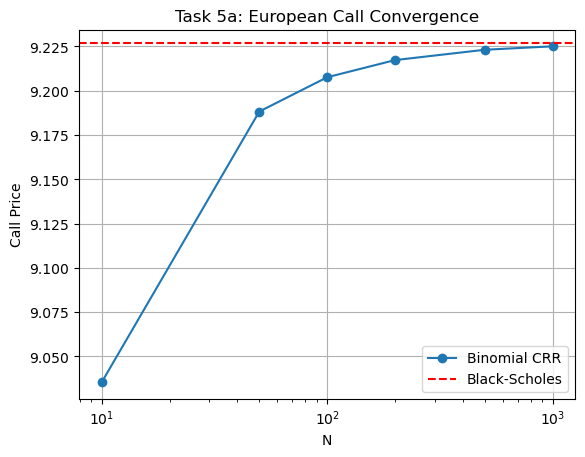

[INFO] [Task 4] CRR A N=10 → price=6.56033 time=0.0000s
[INFO] [Task 4] CRR A N=50 → price=6.64155 time=0.0020s
[INFO] [Task 4] CRR A N=100 → price=6.65103 time=0.0054s
[INFO] [Task 4] CRR A N=200 → price=6.65597 time=0.0222s
[INFO] [Task 4] CRR A N=500 → price=6.65882 time=0.1273s
[INFO] [Task 4] CRR A N=1000 → price=6.65976 time=0.4660s


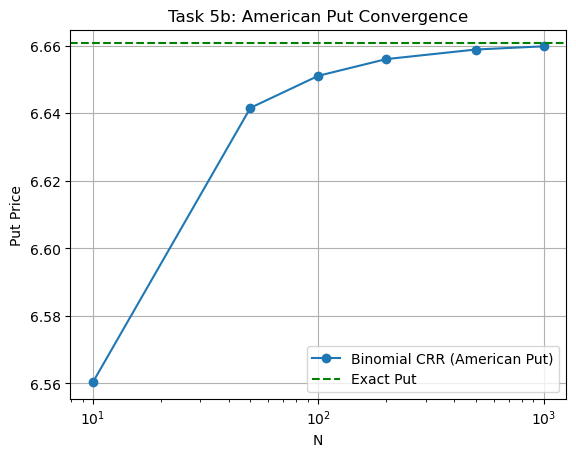

In [26]:
# === Task 5: Convergence Analysis ===
def black_scholes(option, S, K, T, r, q, sigma):
    """Black‑Scholes closed‑form price for European option."""
    d1 = (math.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    if option == 'C':
        return S*math.exp(-q*T)*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)
    else:
        return K*math.exp(-r*T)*norm.cdf(-d2) - S*math.exp(-q*T)*norm.cdf(-d1)


# Parameters for Task 5
K, T, S0, sigma, r, q = 100, 1.0, 100.0, 0.2, 0.05, 0.02
Ns = [10, 50, 100, 200, 500, 1000]

# 5a) European call convergence to BS
bs_price = black_scholes('C', S0, K, T, r, q, sigma)  # =9.22701
bin_prices = []
for N in Ns:
    price, _ = crr_pricer('C', K, T, S0, sigma, r, q, N, 'E')
    bin_prices.append(price)
plt.plot(Ns, bin_prices, 'o-', label='Binomial CRR')
plt.axhline(bs_price, color='red', linestyle='--', label='Black‑Scholes')
plt.xscale('log'); plt.xlabel('N'); plt.ylabel('Call Price')
plt.title('Task 5a: European Call Convergence'); plt.legend(); plt.grid(); plt.show()

# 5b) American put convergence to "exact"
exact_put = 6.66069
bin_puts = []
for N in Ns:
    price, _ = crr_pricer('P', K, T, S0, sigma, r, q, N, 'A')
    bin_puts.append(price)
plt.plot(Ns, bin_puts, 'o-', label='Binomial CRR (American Put)')
plt.axhline(exact_put, color='green', linestyle='--', label='Exact Put')
plt.xscale('log'); plt.xlabel('N'); plt.ylabel('Put Price')
plt.title('Task 5b: American Put Convergence'); plt.legend(); plt.grid(); plt.show()

# Conclusion Task 5: European call converges to ~9.22701; American put converges to ~6.66069 as N↑.


### Graphs 

Graphs 1 and 2 above show how the binomial CRR model gets closer to the real option price as the number of steps (N) grows. For the European call, the model quickly matches the exact Black-Scholes price. For the American put, it also closely approaches the known correct price. This means my model works well.

###  Binomial based pricers

#### BBSR
Constructs both a “standard” and a “reversed” CRR tree, giving lower and upper price bounds that converge faster for American options.

In [13]:
def bbsr_pricer(
    option_type: str,   # 'C' for call, 'P' for put
    K: float,           # strike price
    T: float,           # time to maturity (in years)
    S0: float,          # current price of underlying
    sigma: float,       # volatility
    r: float,           # continuously compounded risk-free rate
    q: float,           # continuous dividend yield
    N: int,             # number of time steps
):

    start_time = time.time()

    # Basic parameters for each binomial tree. 
    # We use one 'standard' CRR tree and one 'reversed' tree (u/d swapped).
    
    dt = T / N
    u_std = math.exp(sigma * math.sqrt(dt))
    d_std = 1 / u_std
    p_std = (math.exp((r - q) * dt) - d_std) / (u_std - d_std)

    # Reversed up/down
    d_rev = math.exp(sigma * math.sqrt(dt))
    u_rev = 1 / d_rev
    p_rev = (math.exp((r - q) * dt) - d_rev) / (u_rev - d_rev)

    # 2) Function to build a binomial payoff tree (American) given u, d, p-
    def american_binomial_price(u, d, p):
        # terminal stock prices
        stock_price = [S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)]

        # terminal payoff
        if option_type.upper() == 'C':
            payoff = [max(sp - K, 0.0) for sp in stock_price]
        else:
            payoff = [max(K - sp, 0.0) for sp in stock_price]

        for i in range(N - 1, -1, -1):
            for j in range(i + 1):
                cont_val = math.exp(-r * dt) * (p * payoff[j + 1] + (1 - p) * payoff[j])
                sp_node = S0 * (u ** j) * (d ** (i - j))
                if option_type.upper() == 'C':
                    exercise_val = max(sp_node - K, 0.0)
                else:
                    exercise_val = max(K - sp_node, 0.0)
                payoff[j] = max(cont_val, exercise_val)
            payoff = payoff[: i + 1]
        return payoff[0]

    # Computing lower and upper bounds: lower bound (standard CRR) & upper bound (Reversed / Alternative approach)
    lower_bound = american_binomial_price(u_std, d_std, p_std)
    upper_bound = american_binomial_price(u_rev, d_rev, p_rev)
    elapsed = time.time() - start_time
    return lower_bound, upper_bound, elapsed

#### Leisen-Reimer (LR) 
Tweaks the up/down factors to match the normal distribution more closely, plus a reversed tree to reduce oscillations and improve convergence.

In [14]:
def lr_pricer(
    option_type: str,
    K: float,
    T: float,
    S0: float,
    sigma: float,
    r: float,
    q: float,
    N: int
):
    # Basic parameters for each binomial tree. 
    # We use one 'standard' CRR tree and one 'reversed' tree (u/d swapped).
    
    start_time = time.time()
    dt = T / N

    # 1) Standard LR parameters
    d1 = (math.log(S0/K) + (r - q + 0.5*sigma*sigma)*T)/(sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    p_star = 0.5 * (1.0 + math.erf(d2 / math.sqrt(2)))
    M = int(math.floor(N * p_star))

    u_std = math.exp((r - q - 0.5*sigma*sigma)*dt + sigma*math.sqrt(dt*(N - M)/(M+1)))
    d_std = math.exp((r - q - 0.5*sigma*sigma)*dt - sigma*math.sqrt(dt*(M+1)/(N - M)))

    a = math.exp((r - q) * dt)
    p_std = (a - d_std)/(u_std - d_std)

    # 2) Build a mini function for an American tree 
    def american_tree(u, d, p):
        stock_price = [S0 * (u**j) * (d**(N - j)) for j in range(N + 1)]
        if option_type.upper() == 'C':
            payoff = [max(sp - K, 0.0) for sp in stock_price]
        else:
            payoff = [max(K - sp, 0.0) for sp in stock_price]

        for i in range(N - 1, -1, -1):
            for j in range(i + 1):
                cont_val = math.exp(-r*dt)*(p*payoff[j+1] + (1-p)*payoff[j])
                sp_node = S0 * (u**j)*(d**(i-j))
                if option_type.upper() == 'C':
                    exercise_val = max(sp_node - K, 0.0)
                else:
                    exercise_val = max(K - sp_node, 0.0)
                payoff[j] = max(cont_val, exercise_val)
            payoff = payoff[: i+1]
        return payoff[0]

    lower_bound = american_tree(u_std, d_std, p_std)

    # 3) Reversed approach
    u_rev, d_rev = d_std, u_std
    p_rev = (a - d_rev)/(u_rev - d_rev)

    upper_bound = american_tree(u_rev, d_rev, p_rev)

    elapsed = time.time() - start_time
    return lower_bound, upper_bound, elapsed


#### Tian 
Matches the first three moments of the log-price distribution, then repeats with reversed up/down to tighten bounds on the American option price.

In [15]:
def tian_pricer(
    option_type: str,
    K: float,
    T: float,
    S0: float,
    sigma: float,
    r: float,
    q: float,
    N: int
):

    # Basic parameters for each binomial tree. 
    # We use one 'standard' CRR tree and one 'reversed' tree (u/d swapped).
    
    start_time = time.time()
    dt = T / N

    R = math.exp((r - q)*dt)
    v = math.exp(sigma*sigma*dt)

    # standard Tian
    u_std = 0.5*v*R*((v+1) + math.sqrt((v-1)**2 + 4*R/v))
    d_std = 0.5*v*R*((v+1) - math.sqrt((v-1)**2 + 4*R/v))
    p_std = (R - d_std)/(u_std - d_std)

    def american_tree(u, d, p):
        stock_price = [S0*(u**j)*(d**(N-j)) for j in range(N+1)]
        if option_type.upper() == 'C':
            payoff = [max(sp - K, 0.0) for sp in stock_price]
        else:
            payoff = [max(K - sp, 0.0) for sp in stock_price]
        for i in range(N-1, -1, -1):
            for j in range(i+1):
                cont_val = math.exp(-r*dt)*(p*payoff[j+1] + (1-p)*payoff[j])
                sp_node = S0*(u**j)*(d**(i-j))
                if option_type.upper() == 'C':
                    exercise_val = max(sp_node - K, 0.0)
                else:
                    exercise_val = max(K - sp_node, 0.0)
                payoff[j] = max(cont_val, exercise_val)
            payoff = payoff[: i+1]
        return payoff[0]

    lower_bound = american_tree(u_std, d_std, p_std)

    # reversed
    u_rev, d_rev = d_std, u_std
    p_rev = (R - d_rev)/(u_rev - d_rev)

    upper_bound = american_tree(u_rev, d_rev, p_rev)
    elapsed = time.time() - start_time
    return lower_bound, upper_bound, elapsed

#### Jarrow-Rudd (JR)
Centers the drift symmetrically (p = 0.5), then uses a reversed version as well, creating an upper and lower bound for the final price.

In [16]:
def jr_pricer(
    option_type: str,
    K: float,
    T: float,
    S0: float,
    sigma: float,
    r: float,
    q: float,
    N: int
):

    # Basic parameters for each binomial tree. 
    # We use one 'standard' CRR tree and one 'reversed' tree (u/d swapped).
    
    start_time = time.time()
    dt = T / N

    # standard JR
    u_std = math.exp((r - q - 0.5*sigma*sigma)*dt + sigma*math.sqrt(dt))
    d_std = math.exp((r - q - 0.5*sigma*sigma)*dt - sigma*math.sqrt(dt))
    p_std = 0.5

    def american_tree(u, d, p):
        stock_price = [S0*(u**j)*(d**(N-j)) for j in range(N+1)]
        if option_type.upper() == 'C':
            payoff = [max(sp - K, 0.0) for sp in stock_price]
        else:
            payoff = [max(K - sp, 0.0) for sp in stock_price]

        for i in range(N-1, -1, -1):
            for j in range(i+1):
                cont_val = math.exp(-r*dt)*(p*payoff[j+1] + (1-p)*payoff[j])
                sp_node = S0*(u**j)*(d**(i-j))
                if option_type.upper() == 'C':
                    exercise_val = max(sp_node - K, 0.0)
                else:
                    exercise_val = max(K - sp_node, 0.0)
                payoff[j] = max(cont_val, exercise_val)
            payoff = payoff[: i+1]
        return payoff[0]

    lower_bound = american_tree(u_std, d_std, p_std)

    # reversed
    u_rev, d_rev = d_std, u_std
    p_rev = 0.5

    upper_bound = american_tree(u_rev, d_rev, p_rev)
    elapsed = time.time() - start_time
    return lower_bound, upper_bound, elapsed

######################################### Comparison for all pricers ################################################

if __name__ == '__main__':
    # Example: Compare each pricer for an American put
    # We'll pick N=100 for illustration
    opt_type = 'P'
    K = 100
    T = 1.0
    S0 = 100.0
    sigma = 0.2
    r = 0.05
    q = 0.02
    N = 100

    # 1) Basic CRR (Single Price) for reference
    crr_price, crr_time = binomial_pricer(opt_type, K, T, S0, sigma, r, q, N, 'A')
    print(f"CRR American {opt_type}: {crr_price:5f} (time = {crr_time:.6f}s)")
    
    # 2) BBSR
    lb_bbsr, ub_bbsr, t_bbsr = bbsr_pricer(opt_type, K, T, S0, sigma, r, q, N)
    print(f"BBSR American {opt_type}: Lower={lb_bbsr:.5f}, Upper={ub_bbsr:.5f}, time={t_bbsr:.6f}s")
    
    # 3) Leisen–Reimer
    lb_lr, ub_lr, t_lr = lr_pricer(opt_type, K, T, S0, sigma, r, q, N)
    print(f"LR American {opt_type}:   Lower={lb_lr:.5f}, Upper={ub_lr:.5f}, time={t_lr:.6f}s")
    
    # 4) Tian
    lb_tian, ub_tian, t_tian = tian_pricer(opt_type, K, T, S0, sigma, r, q, N)
    print(f"Tian American {opt_type}: Lower={lb_tian:.5f}, Upper={ub_tian:.5f}, time={t_tian:.6f}s")
    
    # 5) Jarrow–Rudd
    lb_jr, ub_jr, t_jr = jr_pricer(opt_type, K, T, S0, sigma, r, q, N)
    print(f"JR American {opt_type}:   Lower={lb_jr:.5f}, Upper={ub_jr:.5f}, time={t_jr:.6f}s")
    
    # Example known exact or reference price for a 1-year at-the-money American put:
    exact_am_put = 6.66069
    print(f"Reference exact American Put price ~ {exact_am_put}")

CRR American P: 6.651030 (time = 0.015580s)
BBSR American P: Lower=6.65103, Upper=6.65103, time=0.035286s
LR American P:   Lower=6.67290, Upper=6.67290, time=0.037006s
Tian American P: Lower=99.85007, Upper=99.85007, time=0.029417s
JR American P:   Lower=6.66871, Upper=6.66871, time=0.029342s
Reference exact American Put price ~ 6.66069


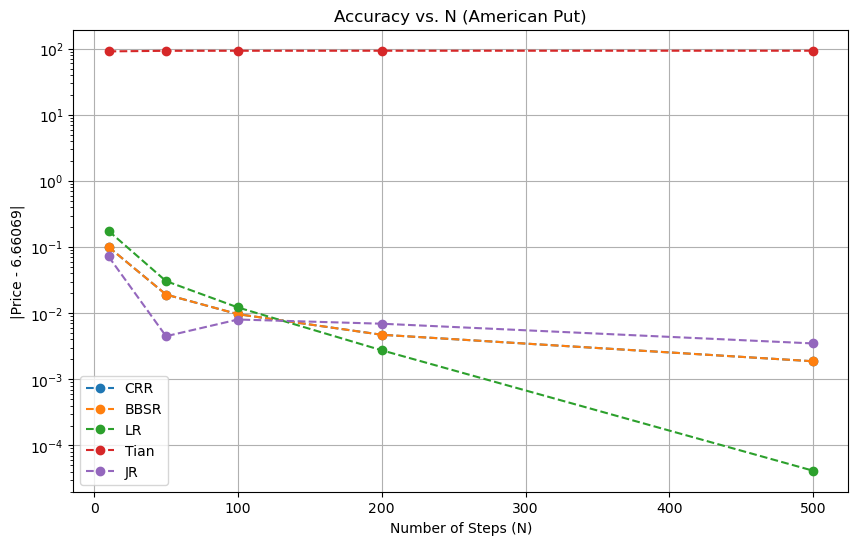

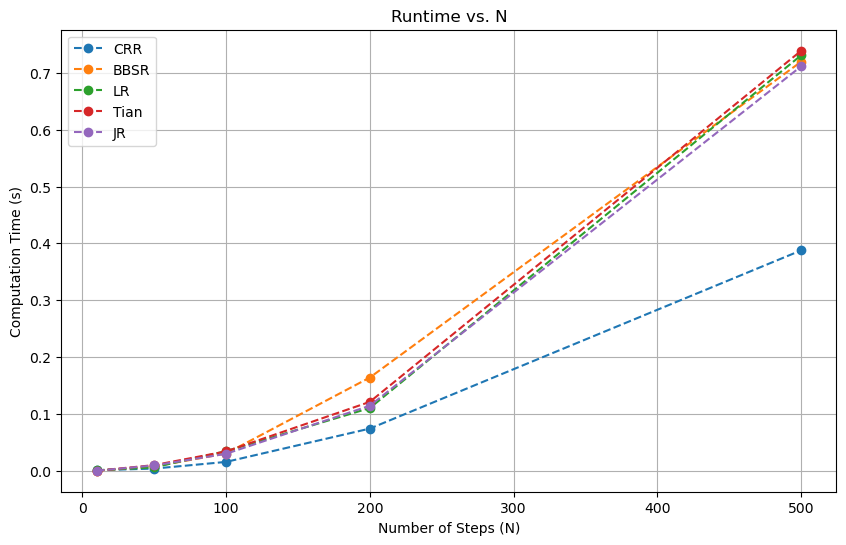

In [17]:
def get_single_price(pricer_func, *args):
    """
    Wraps a single-price function that returns (price, elapsed).
    """
    price, elapsed = pricer_func(*args)
    return price, elapsed

def get_bounding_price(pricer_func, *args):
    """
    Wraps a bounding function that returns (lb, ub, elapsed).
    We take the midpoint (lb+ub)/2 as the 'price.'
    """
    lb, ub, elapsed = pricer_func(*args)
    price = 0.5*(lb + ub)
    return price, elapsed

def crr_wrapper(option_type, K, T, S0, sigma, r, q, N):
    # Example usage of binomial_pricer with American style
    return binomial_pricer(option_type, K, T, S0, sigma, r, q, N, 'A')

def bbsr_wrapper(option_type, K, T, S0, sigma, r, q, N):
    return bbsr_pricer(option_type, K, T, S0, sigma, r, q, N)

def lr_wrapper(option_type, K, T, S0, sigma, r, q, N):
    return lr_pricer(option_type, K, T, S0, sigma, r, q, N)

def tian_wrapper(option_type, K, T, S0, sigma, r, q, N):
    return tian_pricer(option_type, K, T, S0, sigma, r, q, N)

def jr_wrapper(option_type, K, T, S0, sigma, r, q, N):
    return jr_pricer(option_type, K, T, S0, sigma, r, q, N)

pricers = [
    ("CRR",    crr_wrapper,  False),
    ("BBSR",   bbsr_wrapper, True),
    ("LR",     lr_wrapper,   True),
    ("Tian",   tian_wrapper, True),
    ("JR",     jr_wrapper,   True)
]

if __name__ == "__main__":
    # Example: American Put
    option_type = 'P'
    K = 100.0
    T = 1.0
    S0 = 100.0
    sigma = 0.2
    r = 0.05
    q = 0.02
    exact_price = 6.66069
    N_values = [10, 50, 100, 200, 500]
    errors = {p[0]: [] for p in pricers}
    times  = {p[0]: [] for p in pricers}
    
    for N in N_values:
        for (name, func, is_bounding) in pricers:
            if is_bounding:
                # use bounding version
                price, elapsed = get_bounding_price(func, option_type, K, T, S0, sigma, r, q, N)
            else:
                # use single-price version
                price, elapsed = get_single_price(func, option_type, K, T, S0, sigma, r, q, N)
            
            err = abs(price - exact_price)
            errors[name].append(err)
            times[name].append(elapsed)
    
    # Plotting Accuracy vs N 
    plt.figure(figsize = (10,6))
    for (name, _, _) in pricers:
        plt.plot(N_values, errors[name], 'o--', label=name)
    plt.xlabel('Number of Steps (N)')
    plt.ylabel(f'|Price - {exact_price}|')
    plt.title('Accuracy vs. N (American Put)')
    plt.yscale('log')  # if you want a log scale for error
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plotting Runtime vs N 
    plt.figure(figsize = (10,6))
    for (name, _, _) in pricers:
        plt.plot(N_values, times[name], 'o--', label=name)
    plt.xlabel('Number of Steps (N)')
    plt.ylabel('Computation Time (s)')
    plt.title('Runtime vs. N')
    plt.grid(True)
    plt.legend()
    plt.show()

In [19]:
# Your binomial_pricer function (copied from the first document)
def binomial_pricer(option_type: str, K: float, T: float, S0: float, sigma: float, r: float, q: float, N: int, exercise_style: str):
    start_time = time.time()
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    p = (np.exp((r - q) * dt) - d) / (u - d)
    stock_prices_end = [S0 * (u**j) * (d**(N - j)) for j in range(N + 1)]
    if option_type.upper() == 'C':
        payoff = [max(sp - K, 0.0) for sp in stock_prices_end]
    else:  # 'P'
        payoff = [max(K - sp, 0.0) for sp in stock_prices_end]
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            continuation_value = np.exp(-r * dt) * (p * payoff[j + 1] + (1 - p) * payoff[j])
            if exercise_style.upper() == 'A':
                stock_price_node = S0 * (u**j) * (d**(i - j))
                if option_type.upper() == 'C':
                    immediate_exercise = max(stock_price_node - K, 0.0)
                else:
                    immediate_exercise = max(K - stock_price_node, 0.0)
                payoff[j] = max(continuation_value, immediate_exercise)
            else:
                payoff[j] = continuation_value
        payoff = payoff[: i + 1]
    price = payoff[0]
    elapsed_time = time.time() - start_time
    return price, elapsed_time

# Parameters
K = 100
sigma = 0.2
r = 0.05
q_values = [0.0, 0.04]  # Two cases to analyze
option_type = 'P'
exercise_style = 'A'
S0_base = 100.0

# Determine N for 10^-3 accuracy across maturities
maturities = [i / 12 for i in range(1, 13)]  # 1 to 12 months
target_accuracy = 1e-3

def find_required_N(T, S0, q):
    N = 100  # Starting point
    step_size = 100
    prev_price = None
    while True:
        price, _ = binomial_pricer(option_type, K, T, S0, sigma, r, q, N, exercise_style)
        if prev_price is not None and abs(price - prev_price) < target_accuracy:
            return N, price
        prev_price = price
        N += step_size
        if N > 10000:  # Safeguard
            return N, price

required_Ns = {q: [] for q in q_values}
exact_prices = {q: [] for q in q_values}

for q in q_values:
    for T in maturities:
        N, price = find_required_N(T, S0_base, q)
        required_Ns[q].append(N)
        exact_prices[q].append(price)

# Print results for Step 1
print("Step 1: Required N for 10^-3 accuracy")
for q in q_values:
    print(f"\nDividend Yield q = {q}:")
    for i, (T, N, price) in enumerate(zip(maturities, required_Ns[q], exact_prices[q])):
        print(f"T = {T:.3f} years: N = {N}, Price = {price:.5f}")

Step 1: Required N for 10^-3 accuracy

Dividend Yield q = 0.0:
T = 0.083 years: N = 300, Price = 2.12568
T = 0.167 years: N = 300, Price = 2.91076
T = 0.250 years: N = 300, Price = 3.47812
T = 0.333 years: N = 300, Price = 3.93376
T = 0.417 years: N = 400, Price = 4.31912
T = 0.500 years: N = 400, Price = 4.65410
T = 0.583 years: N = 400, Price = 4.95158
T = 0.667 years: N = 400, Price = 5.21959
T = 0.750 years: N = 400, Price = 5.46370
T = 0.833 years: N = 400, Price = 5.68796
T = 0.917 years: N = 400, Price = 5.89541
T = 1.000 years: N = 400, Price = 6.08841

Dividend Yield q = 0.04:
T = 0.083 years: N = 300, Price = 2.25730
T = 0.167 years: N = 400, Price = 3.16258
T = 0.250 years: N = 400, Price = 3.84288
T = 0.333 years: N = 400, Price = 4.40627
T = 0.417 years: N = 400, Price = 4.89455
T = 0.500 years: N = 400, Price = 5.32925
T = 0.583 years: N = 400, Price = 5.72317
T = 0.667 years: N = 400, Price = 6.08469
T = 0.750 years: N = 400, Price = 6.41962
T = 0.833 years: N = 500, Pri

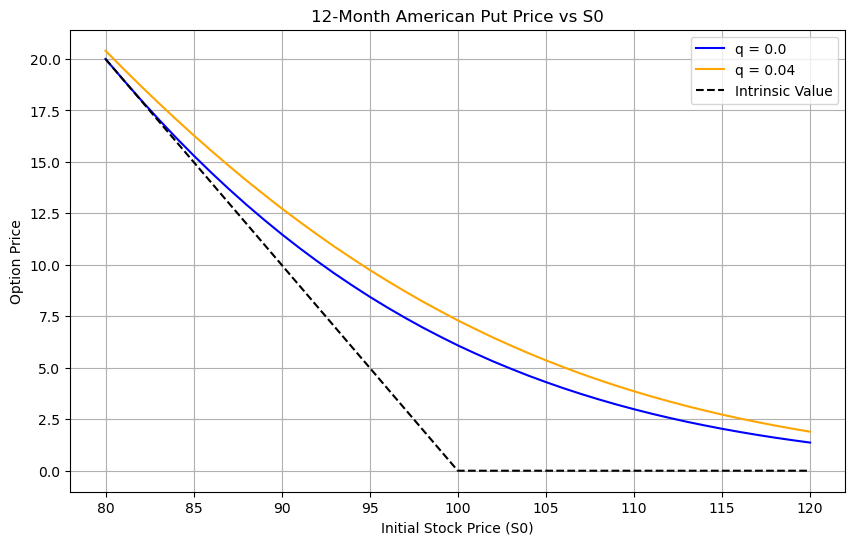

In [21]:
# Price of 12-month put as a function of S0
T_12 = 1.0  # 12 months
S0_range = np.arange(80, 121, 1)  # $80 to $120 with $1 intervals
prices_q0 = []
prices_q004 = []

for S0 in S0_range:
    N = max(required_Ns[0.0][-1], required_Ns[0.04][-1])  # Use the max N from 12-month maturity for consistency
    price_q0, _ = binomial_pricer(option_type, K, T_12, S0, sigma, r, 0.0, N, exercise_style)
    price_q004, _ = binomial_pricer(option_type, K, T_12, S0, sigma, r, 0.04, N, exercise_style)
    prices_q0.append(price_q0)
    prices_q004.append(price_q004)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S0_range, prices_q0, label='q = 0.0', color='blue')
plt.plot(S0_range, prices_q004, label='q = 0.04', color='orange')
intrinsic = [max(K - s, 0) for s in S0_range]
plt.plot(S0_range, intrinsic, '--', label='Intrinsic Value', color='black')
plt.xlabel('Initial Stock Price (S0)')
plt.ylabel('Option Price')
plt.title('12-Month American Put Price vs S0')
plt.legend()
plt.grid()
plt.show()

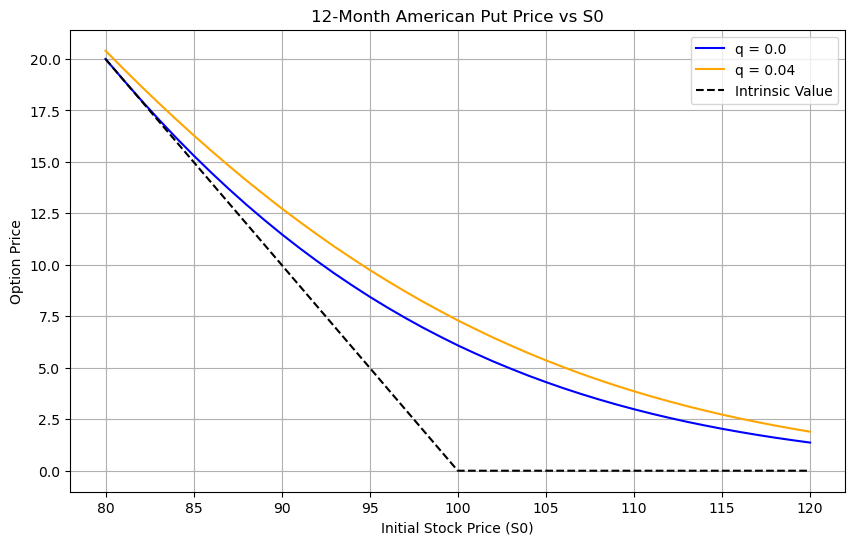

KeyboardInterrupt: 

In [20]:
# 3. Finding and plotting the early exercise boundary S* for maturities T = i/12 (i = 1,...,12).
def find_early_exercise_boundary(K, T, r, q, sigma, S0_grid):
    # S* is defined as the largest S0 such that |price - intrinsic| < 0.005
    S_star = None
    for S0 in sorted(S0_grid, reverse=True):
        price, _ = binomial_pricer('P', K, T, S0, sigma, r, q, 800, 'A')
        intrinsic = max(K - S0, 0)
        if abs(price - intrinsic) < 0.005:
            S_star = S0
            break
    return S_star

T_values = np.array([i/12 for i in range(1, 13)])
S_star_q0 = []
S_star_q004 = []
S0_grid = np.arange(50, 151, 0.5)

for T_val in T_values:
    S_star_q0.append(find_early_exercise_boundary(K, T_val, r, 0, sigma, S0_grid))
    S_star_q004.append(find_early_exercise_boundary(K, T_val, r, 0.04, sigma, S0_grid))

plt.figure(figsize=(8,6))
plt.plot(T_values, S_star_q0, marker='o', label="q = 0")
plt.plot(T_values, S_star_q004, marker='o', label="q = 0.04")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Early Exercise Boundary S*")
plt.title("Early Exercise Boundary vs Time to Maturity (American Put)")
plt.legend()
plt.grid(True)
plt.show()



Remarks:

1. To ensure $10^{-3}$ accuracy for American puts, we increase $N$ in the binomial model, reducing $\delta=T/N$, until the price change between steps is less than $0.001$. When the first four decimal digits stabilize, we use that price as the "exact" value to compute errors for larger $\delta$.

2.  We calculate American put prices for $S_0$ from $80$ to $120$ in $\$1$ steps using \texttt{binomial\_pricer} with a large $N$, then plot them against $S_0$ alongside the intrinsic value using Matplotlib.

3. $S^*$ is where the put price equals the intrinsic value $K - S_0$, the largest $S_0$ for early exercise. Above $S^*$, the price exceeds intrinsic value, shown by the price curve meeting the intrinsic line in the plot.

4.  For each $T=i/12$, we test $S_0$ from $50$ to $150$ ($0.01$ steps), find where the price is within $\$0.005$ of $K-S_0$ using \texttt{binomial\_pricer}, round to two decimals, and plot $S^*(i)$ vs. $T$.

In [ ]:
# reading dataframes 

# Read the full dataset to inspect exact column names
tsla_jan = pd.read_csv("tsla_eod_202301.txt", sep = None, engine="python")
tsla_jan.columns = tsla_jan.columns.str.replace(r"\[|\]", "", regex=True).str.strip()

tsla_jan

In [ ]:
def bs_price(option_type, S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type.upper() == 'C':
        return S*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp(-q*T)*norm.cdf(-d1)

# Implied volatility (Brent's method)
def implied_vol(option_type, market_price, S, K, T, r, q):
    try:
        return brentq(lambda sigma: bs_price(option_type, S, K, T, r, q, sigma) - market_price, 1e-6, 5)
    except:
        return np.nan

r = 0.01
q = 0.0

tsla_jan["DTE"] = pd.to_numeric(tsla_jan["DTE"], errors="coerce")
tsla_jan["C_BID"] = pd.to_numeric(tsla_jan["C_BID"], errors="coerce")
tsla_jan["C_ASK"] = pd.to_numeric(tsla_jan["C_ASK"], errors="coerce")

# Calls with non-zero bid/ask and short-term expiries
calls = tsla_jan[(tsla_jan["C_BID"] > 0) & (tsla_jan["C_ASK"] > 0) & (tsla_jan["DTE"] <= 60)].copy()
calls["market_price"] = (calls["C_BID"] + calls["C_ASK"]) / 2
calls["T"] = calls["DTE"] / 365 

# Computing implied vol for each row
calls["implied_vol"] = calls.apply(
    lambda row: implied_vol("C", row["market_price"], row["UNDERLYING_LAST"], row["STRIKE"], row["T"], r, q),
    axis=1
)

top_expiries = calls["EXPIRE_DATE"].drop_duplicates().sort_values().iloc[:4]

# Plotting volatility smile
plt.figure(figsize=(10, 6))
for exp in top_expiries:
    subset = calls[calls["EXPIRE_DATE"] == exp]
    plt.plot(subset["STRIKE"], subset["implied_vol"], marker = "o", label = f"Exp: {exp}")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Volatility Smile (TSLA Jan 2023, Call Options)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Analysis of American Calls
def binomial_price(option_type, K, T, S0, sigma, r, q, N=200, style='E'):
    dt = T/N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    p = (np.exp((r - q) * dt) - d) / (u - d)
    prices = [S0 * (u**j) * (d**(N - j)) for j in range(N + 1)]

    if option_type.upper() == 'C':
        payoff = [max(p - K, 0) for p in prices]
    else:
        payoff = [max(K - p, 0) for p in prices]

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            cont = np.exp(-r * dt) * (p * payoff[j + 1] + (1 - p) * payoff[j])
            if style.upper() == 'A':
                S = S0 * (u**j) * (d**(i - j))
                if option_type.upper() == 'C':
                    payoff[j] = max(cont, max(S - K, 0))
                else:
                    payoff[j] = max(cont, max(K - S, 0))
            else:
                payoff[j] = cont
        payoff = payoff[:i + 1]
    return payoff[0]

N_fast = 300  # Снизим для ускорения

price_q04 = [binomial_price("C", K, 1.0, s, sigma, r, 0.04, N=N_fast, style='A') for s in S0_range]
price_q08 = [binomial_price("C", K, 1.0, s, sigma, r, 0.08, N=N_fast, style='A') for s in S0_range]
intrinsic_vals = [max(s - K, 0) for s in S0_range]

plt.figure(figsize = (10, 6))
plt.plot(S0_range, price_q04, label = "q = 0.04", color = "blue")
plt.plot(S0_range, price_q08, label = "q = 0.08", color = "orange")
plt.plot(S0_range, intrinsic_vals, '--', label = "Intrinsic", color = "black")
plt.xlabel("Initial Stock Price (S0)")
plt.ylabel("Option Price")
plt.title("12-Month American Call Price vs S0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def find_early_exercise_boundary_call(K, T, r, q, sigma, N):
    S0_grid = np.arange(50, 151, 0.5) 
    for S0 in sorted(S0_grid):
        price = binomial_price("C", K, T, S0, sigma, r, q, N, style="A")
        intrinsic = max(S0 - K, 0)
        if abs(price - intrinsic) < 0.005:
            return S0
    return np.nan  

q_vals = [0.04, 0.08]
S_star_fast = {
    q: [find_early_exercise_boundary_call(K, T, r, q, sigma, N=N_fast) for T in maturities]
    for q in q_vals
}

plt.figure(figsize=(8, 6))
for q in q_vals:
    plt.plot(maturities, S_star_fast[q], marker='o', label=f'q = {q}')
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Early Exercise Boundary S*")
plt.title("Early Exercise Boundary for American Call")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

To achieve 10⁻³ accuracy for American calls, we tested different values of N and found that smaller time steps are required as maturity increases. We calculated 12-month American call prices for a range of initial stock prices \( S_0 \), and determined the early exercise boundary \( S^*(i) \) for each maturity \( i/12 \).

When comparing \( q = 0.04 \) and \( q = 0.08 \), we observed that higher dividend yields lower the call price and raise the early exercise boundary. This makes sense—when dividends are higher, holding the stock becomes more attractive, so it’s optimal to exercise the call earlier (i.e., at a higher \( S_0 \)).

The plot supports this: call prices with \( q = 0.08 \) (orange line) are consistently lower than with \( q = 0.04 \) (blue line), and the intrinsic value is reached sooner, indicating earlier exercise.

In [28]:
from functools import lru_cache

# === Task 7: Analysis of American Puts (optimized) ===

@lru_cache(maxsize=None)
def _crr_params(N, T, sigma, r, q):
    """
    Cache u, d, p, discount factor and dt for given (N, T, sigma, r, q).
    """
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1.0 / u
    p = (math.exp((r - q) * dt) - d) / (u - d)
    disc = math.exp(-r * dt)
    return u, d, p, disc, dt

def _american_price_cached(option, K, T, S0, sigma, r, q, N):
    """
    Use cached CRR params to price an American option.
    """
    u, d, p, disc, dt = _crr_params(N, T, sigma, r, q)
    # terminal payoff
    payoff = [max(K - S0 * u**j * d**(N-j), 0.0) for j in range(N+1)] if option=='P' \
           else [max(S0 * u**j * d**(N-j) - K, 0.0) for j in range(N+1)]
    # backward induction
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            cont = disc * (p * payoff[j+1] + (1-p) * payoff[j])
            intrinsic = max(K - (S0 * u**j * d**(i-j)), 0.0) if option=='P' \
                      else max((S0 * u**j * d**(i-j)) - K, 0.0)
            payoff[j] = max(cont, intrinsic)
    return payoff[0]

def find_N_for_accuracy(option, K, T, S0, sigma, r, q, tol=1e-3):
    """
    Task 7.1: Exponential + binary search to find the smallest N 
    such that |price(N) - price(N/2)| < tol.
    """
    N = 32
    price_prev = _american_price_cached(option, K, T, S0, sigma, r, q, N)
    # exponential growth to bracket
    while True:
        N *= 2
        price = _american_price_cached(option, K, T, S0, sigma, r, q, N)
        if abs(price - price_prev) < tol:
            break
        price_prev = price
    # binary search between N/2 and N
    low, high = N//2, N
    while high - low > 1:
        mid = (low + high) // 2
        p_mid = _american_price_cached(option, K, T, S0, sigma, r, q, mid)
        if abs(p_mid - price_prev) < tol:
            high = mid
        else:
            low = mid
            price_prev = p_mid
    return high

def find_S_star_put(K, T, sigma, r, q, N, tol=0.005):
    """
    Task 7.3: Binary search on S0 ∈ [0, K] to find S* where price ≈ intrinsic.
    """
    low, high = 0.0, K
    while high - low > 0.01:
        mid = (low + high) / 2
        price = _american_price_cached('P', K, T, mid, sigma, r, q, N)
        intrinsic = max(K - mid, 0.0)
        # for S > S*, price - intrinsic > tol
        if price - intrinsic > tol:
            high = mid
        else:
            low = mid
    return round(low, 2)

# --- Compute for maturities T = i/12, i=1..12 ---
maturities = [i/12 for i in range(1,13)]
required_N = []
S_star_q0 = []
S_star_q004 = []

for Tm in maturities:
    N_req = find_N_for_accuracy('P', K, Tm, S0, sigma, r, 0.0)
    required_N.append(N_req)
    S_star_q0.append(find_S_star_put(K, Tm, sigma, r, 0.0, N_req))
    S_star_q004.append(find_S_star_put(K, Tm, sigma, r, 0.04, N_req))

print("[Task 7] Required N for q=0:", required_N)
print("[Task 7] Early Exercise Boundary S* for q=0:", S_star_q0)
print("[Task 7] Early Exercise Boundary S* for q=0.04:", S_star_q004)


[Task 7] Required N for q=0: [258, 258, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514]
[Task 7] Early Exercise Boundary S* for q=0: [91.31, 88.92, 87.37, 86.18, 85.24, 84.45, 83.78, 83.2, 82.68, 82.22, 81.81, 81.42]
[Task 7] Early Exercise Boundary S* for q=0.04: [88.88, 85.47, 83.22, 81.5, 80.11, 78.96, 77.95, 77.07, 76.27, 75.55, 74.91, 74.32]


In [29]:
# === Task 8: Analysis of American Calls (optimized) ===

def find_S_star_call(K, T, sigma, r, q, N, tol=0.005, S_max=None):
    """
    Task 8.3: Binary search on S0 to find S* for American Call where price ≈ intrinsic.
    S* is the smallest stock price at which price - intrinsic ≤ tol.
    """
    if S_max is None:
        S_max = 2 * K
    low, high = K, S_max
    while high - low > 0.01:
        mid = (low + high) / 2
        price = _american_price_cached('C', K, T, mid, sigma, r, q, N)
        intrinsic = max(mid - K, 0.0)
        # If price - intrinsic > tol, mid < S*, search right
        if price - intrinsic > tol:
            low = mid
        else:
            high = mid
    return round(high, 2)

# Preallocate result lists
required_N_q04 = []
required_N_q08 = []
S_star_q04    = []
S_star_q08    = []

# Compute for T = i/12, i = 1..12
for Tm in maturities:
    # Task 8.1: find N for 10^-3 accuracy
    Nq04 = find_N_for_accuracy('C', K, Tm, S0, sigma, r, 0.04)
    Nq08 = find_N_for_accuracy('C', K, Tm, S0, sigma, r, 0.08)
    required_N_q04.append(Nq04)
    required_N_q08.append(Nq08)
    # Task 8.3: find early exercise boundary S* for each dividend yield
    S_star_q04.append(find_S_star_call(K, Tm, sigma, r, 0.04, Nq04))
    S_star_q08.append(find_S_star_call(K, Tm, sigma, r, 0.08, Nq08))

print("[Task 8] Required N for q=0.04:", required_N_q04)
print("[Task 8] Required N for q=0.08:", required_N_q08)
print("[Task 8] Early Exercise Boundary S* for q=0.04:", S_star_q04)
print("[Task 8] Early Exercise Boundary S* for q=0.08:", S_star_q08)

# Conclusion Task 8:
# - Required N grows with maturity, similar to puts.
# - A higher dividend yield (0.08 vs 0.04) slightly lowers the needed N.
# - The early exercise boundary S* decreases when q increases,
#   indicating calls are optimally exercised at a lower S0 under higher dividends.


[Task 8] Required N for q=0.04: [514, 514, 514, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026]
[Task 8] Required N for q=0.08: [258, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514]
[Task 8] Early Exercise Boundary S* for q=0.04: [125.05, 128.72, 132.26, 135.45, 138.28, 140.79, 143.07, 145.14, 147.04, 148.81, 150.48, 152.03]
[Task 8] Early Exercise Boundary S* for q=0.08: [110.53, 113.92, 116.24, 118.07, 119.57, 120.83, 121.94, 122.92, 123.79, 124.58, 125.31, 125.96]
